# IWTC Raw Source Indexing

This notebook executes the raw source indexing workflow defined in:

- `docs/raw_source_indexing_design.md`

It is intended for hands-on execution and experimentation. Conceptual scope, responsibilities, and workflow design are defined in the linked design document.

This notebook operates on a single world repository.

A minimal example of `world_repository.yml` is provided in this repository
under:

- `data/config_examples/world_repository.yml`

You may copy and adapt that example for your own world repository.

## Phase 0: Parameters

This notebook operates on a **campaign world repository** and produces draft, machine-generated indexes for human review.

In this phase, you tell the notebook **which world it is operating on** and **how broad this run should be**.

At a high level:
- You point the notebook at a world descriptor file that explains how your world’s files are organized.
- You can optionally restrict this run to specific files or folders if you are working on a subset of material.
- You choose whether to review discovered files interactively or process everything automatically.

You do **not** need to understand internal data structures or file parsing to set these parameters.  
The goal is simply to answer: *“What world am I indexing, and how much of it do I want to work on right now?”*

The code cell below contains inline comments explaining each parameter in concrete terms.


In [12]:
# Phase 0: Parameters

# Absolute path to the world_repository.yml descriptor.
WORLD_REPOSITORY_DESCRIPTOR = (
    "/Users/charissophia/obsidian/Iron Wolf Trading Company/_meta/descriptors/world_repository.yml"
)

# Optional override: use these paths instead of descriptor sources for this run.
# Examples:
#   OVERRIDE_PATHS = "/Users/you/path/to/file_or_dir"
#   OVERRIDE_PATHS = ["/Users/you/path/a", "/Users/you/path/b"]
OVERRIDE_PATHS = None

# Selection behavior:
#   "PROMPT" -> list candidates and prompt for selection
#   "ALL"    -> select all candidates
SOURCE_MODE = "ALL"

# Internal run metadata (do not edit)
from datetime import datetime
print(f"Notebook run initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Notebook run initialized at: 2026-01-08 14:58


## Phase 1: Load and validate world descriptor

Before this notebook can safely read or write anything, it must be confident that it understands the **structure of the world repository**.

In this phase, the notebook:

- Loads the world repository descriptor file you provided
- Confirms that it is readable and structurally valid
- Extracts only the information this notebook needs
- Verifies that referenced paths actually exist and are usable

This phase answers a single question:

**“Can I trust this descriptor enough to proceed?”**

If the answer is *no*, the notebook will stop with clear, actionable error messages explaining what needs to be fixed in the descriptor file.  
Nothing is modified, created, or scanned until this check succeeds.

This phase does **not** interpret world lore, indexing rules, or heuristics.  
It only establishes that the filesystem layout described by the world is coherent and usable.

In [13]:
# Phase 1a: Load and parse world repository descriptor

from pathlib import Path
import yaml

# Locate descriptor file
descriptor_path = Path(WORLD_REPOSITORY_DESCRIPTOR)

if not descriptor_path.exists():
    raise FileNotFoundError(
        "World repository descriptor file was not found.\n"
        f"Path provided:\n  {descriptor_path}\n\n"
        "What to do:\n"
        "- Confirm the file exists at this location or fix the Parameters cell\n"
        "- If you just edited the Parameters cell, rerun Phase 0 and then rerun this cell\n"
    )

# Read and parse YAML
try:
    with descriptor_path.open("r", encoding="utf-8") as f:
        world_repo = yaml.safe_load(f)
except Exception:
    raise ValueError(
        "The world repository descriptor could not be read.\n"
        "This usually indicates a YAML formatting problem.\n\n"
        f"File:\n  {descriptor_path}\n\n"
        "What to do:\n"
        "- Compare the file against the example world_repository.yml\n"
        "- Paste the contents into https://www.yamllint.com/\n"
        "- Fix any reported issues, save the file, and rerun this cell"
    )

# Validate basic structure
if not isinstance(world_repo, dict):
    raise ValueError(
        "The world repository descriptor was read, but its structure is not usable.\n"
        "The file must be a YAML mapping (top-level `name: value` entries).\n\n"
        "What to do:\n"
        "- Compare the file against the example world_repository.yml\n"
        "- Ensure it uses clear `name: value` lines\n"
        "- Fix the file and rerun this cell"
    )

print(f"World repository descriptor loaded successfully: {descriptor_path.name}")

# cleanup: remove local variables
del f, yaml

World repository descriptor loaded successfully: world_repository.yml


In [14]:
# Phase 1b: Extract only the information this notebook needs (raw descriptor values)

errors = []

# --- required raw values ---
DESC_WORLD_ROOT_RAW = world_repo.get("world_root")

# sources.read_paths can contain either:
# - strings (backward compatible): "- _local/recollections"
# - mappings: "- path: _local/session_notes\n  type: session_notes"
sources_block = world_repo.get("sources")
DESC_SOURCES_READ_PATHS_RAW = (
    sources_block.get("read_paths") if isinstance(sources_block, dict) else None
)

# working_drafts.path is required for this notebook
working_drafts_block = world_repo.get("working_drafts")
DESC_WORKING_DRAFTS_PATH_RAW = (
    working_drafts_block.get("path") if isinstance(working_drafts_block, dict) else None
)

# --- validate presence only (not filesystem usability yet) ---
if not DESC_WORLD_ROOT_RAW:
    errors.append("Missing required entry: world_root")

if DESC_SOURCES_READ_PATHS_RAW is None:
    errors.append("Missing required entry: sources.read_paths")

if not DESC_WORKING_DRAFTS_PATH_RAW:
    errors.append("Missing required entry: working_drafts.path")

if errors:
    raise ValueError(
        "World repository descriptor is missing required entries:\n- "
        + "\n- ".join(errors)
        + "\n\nWhat to do:\n"
          "- Edit your world_repository.yml\n"
          "- Use the example descriptor as a reference\n"
          "- Save the file and rerun Phase 1a, then rerun this cell\n"
          "\nNote: This check only confirms the entries exist. Path usability is validated in the next phase."
    )

print("Descriptor contains the required entries for this notebook.")

# Cleanup true temporaries
del errors, sources_block, working_drafts_block

Descriptor contains the required entries for this notebook.


In [15]:
# Phase 1c: Validate descriptor paths and build the validated contract variables
#
# Outputs (validated):
#   WORLD_ROOT: Path
#   DESCRIPTOR_SOURCES: list[dict]   # each {"path": Path, "type": str}
#   WORKING_DRAFTS_PATH: Path
#
# Inputs (raw, from Phase 1b):
#   DESC_WORLD_ROOT_RAW
#   DESC_SOURCES_READ_PATHS_RAW
#   DESC_WORKING_DRAFTS_PATH_RAW

from pathlib import Path

errors = []

# Validate world_root
world_root = Path(DESC_WORLD_ROOT_RAW)

if str(world_root).startswith("~"):
    errors.append("world_root: '~' is not allowed. Use a full absolute path (see the example descriptor).")
elif not world_root.is_absolute():
    errors.append(
        "world_root must be an absolute path (macOS/Linux starts with /, Windows starts with a drive like C:\\). "
        "See the example descriptor."
    )
elif not world_root.is_dir():
    errors.append(f"world_root must be an existing directory. This path does not exist: {world_root}")
else:
    world_root = world_root.resolve()

# Stop early if world_root is invalid (can't resolve relative paths safely)
if errors:
    raise ValueError("Descriptor path validation failed:\n- " + "\n- ".join(errors))

# Validate sources.read_paths -> list of {path: Path, type: str}
entries = DESC_SOURCES_READ_PATHS_RAW
typed_sources = []

if not isinstance(entries, list):
    errors.append(
        "sources.read_paths must be a YAML list (each line starts with '-') of paths or {path,type} mappings."
    )
else:
    for entry in entries:
        if isinstance(entry, str):
            path_value = entry
            source_type = "unknown"

        elif isinstance(entry, dict):
            path_value = entry.get("path")
            if not path_value:
                errors.append("sources.read_paths entry is missing 'path'.")
                continue
            source_type = entry.get("type") or "unknown"

        else:
            errors.append("sources.read_paths entries must be a path string or a {path: ..., type: ...} mapping.")
            continue

        try:
            p = Path(path_value)

            if str(p).startswith("~"):
                errors.append(
                    "sources.read_paths contains a path starting with '~'. "
                    "Use an absolute path or a path relative to world_root."
                )
                continue

            if not p.is_absolute():
                p = world_root / p

            if not p.exists():
                errors.append(f"sources.read_paths points to a path that does not exist: {p}")
                continue

            typed_sources.append({"path": p.resolve(), "type": source_type})

        except Exception:
            errors.append(
                "sources.read_paths contains a path value that cannot be interpreted as a filesystem path."
            )

# Validate working_drafts.path
drafts_path = Path(DESC_WORKING_DRAFTS_PATH_RAW)

if str(drafts_path).startswith("~"):
    errors.append("working_drafts.path cannot start with '~'. Use a full path or a path relative to world_root.")
else:
    if not drafts_path.is_absolute():
        drafts_path = world_root / drafts_path

    if drafts_path.exists():
        if not drafts_path.is_dir():
            errors.append(
                f"working_drafts.path must be a directory (this process may generate multiple files): {drafts_path}"
            )
        else:
            drafts_path = drafts_path.resolve()
    else:
        drafts_parent = drafts_path.parent
        if not drafts_parent.exists():
            errors.append(f"working_drafts.path does not exist and its parent directory is missing: {drafts_path}")
            errors.append("Action: create the parent directories or update working_drafts.path.")
        elif not drafts_parent.is_dir():
            errors.append(f"working_drafts.path parent exists but is not a directory: {drafts_parent}")
        else:
            drafts_probe = drafts_parent / ".iwtc_tools_write_probe.tmp"
            try:
                drafts_probe.write_text("test", encoding="utf-8")
                errors.append(f"working_drafts.path does not exist yet, but it appears creatable: {drafts_path}")
                errors.append("Action: create this directory now (recommended) or allow the tool to create it later.")
            except Exception:
                errors.append(
                    f"working_drafts.path does not exist and may not be creatable (parent not writable): {drafts_path}"
                )
                errors.append("Action: choose a different working_drafts.path or adjust permissions.")
            finally:
                if drafts_probe.exists():
                    drafts_probe.unlink()

            # branch cleanup
            del drafts_probe
        del drafts_parent

# Raise if any validation failed
if errors:
    raise ValueError(
        "Descriptor path validation failed:\n- "
        + "\n- ".join(errors)
        + f"\n\nFix entries in: {Path(WORLD_REPOSITORY_DESCRIPTOR).name}\n"
          "Then rerun Phase 1a, Phase 1b, and this cell."
    )

# Publish validated outputs (no ENV dict)
WORLD_ROOT = world_root
DESCRIPTOR_SOURCES = typed_sources
WORKING_DRAFTS_PATH = drafts_path

print("Descriptor paths are usable for this notebook.")
print(f"world_root: {WORLD_ROOT}")
print(
    "sources.read_paths (resolved, no override):"
    if OVERRIDE_PATHS is None
    else "sources.read_paths (resolved, possible override):"
)
for src in DESCRIPTOR_SOURCES:
    print(f" - {src['path']}  [{src['type']}]")
print(f"working_drafts.path: {WORKING_DRAFTS_PATH}")

# Local cleanup (validated outputs remain)
del errors, entries, typed_sources, world_root, drafts_path, src

Descriptor paths are usable for this notebook.
world_root: /Users/charissophia/obsidian/Iron Wolf Trading Company
sources.read_paths (resolved, no override):
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts  [auto_transcripts]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/pbp_transcripts  [pbp_transcripts]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/session_notes  [session_notes]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/planning_notes  [planning_notes]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/recollections  [unknown]
working_drafts.path: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/machine_wip


## Phase 2: Discover source files

Before this notebook can index or analyze anything, it must determine **which files are available to work with**.

In this phase, the notebook:
- Determines which source locations to use (either override paths you provided, or the repository’s declared sources)
- Recursively scans those locations for supported file types
- Groups discovered files by directory for human-readable review
- Assigns each discovered file a stable numeric ID
- Associates each file with its declared source type (if available)

This phase answers a single question:

**“What source files are available for processing right now?”**

If no supported files are found, the notebook will stop and explain why.  
Nothing is read, modified, or written during discovery.

Depending on your configuration:
- If SOURCE_MODE is "PROMPT", you will be prompted to choose which files to process
- Otherwise, all discovered files will be selected without prompting

This phase does **not** read file contents, interpret text, or apply chunking rules.  
It only establishes the complete, concrete list of candidate files that later phases may operate on.

In [16]:
# Phase 2a: Determine effective source roots (descriptor vs override) and report what will be scanned.
#
# Inputs:
#   WORLD_ROOT
#   DESCRIPTOR_SOURCES   # list of {"path": Path, "type": str}
#   OVERRIDE_PATHS       # None | str | list[str]
#
# Outputs:
#   EFFECTIVE_SOURCE_ROOTS  # list of {"path": Path, "type": str}
#   SOURCE_ORIGIN           # str

from pathlib import Path

descriptor_sources = DESCRIPTOR_SOURCES
world_root = WORLD_ROOT

# Fast lookup: inherit descriptor type for any resolved path we match.
descriptor_type_by_path = {src["path"]: (src.get("type") or "unknown") for src in descriptor_sources}

EFFECTIVE_SOURCE_ROOTS = []
SOURCE_ORIGIN = None

if OVERRIDE_PATHS is None:
    SOURCE_ORIGIN = "descriptor"
    EFFECTIVE_SOURCE_ROOTS = list(descriptor_sources)

elif isinstance(OVERRIDE_PATHS, str):
    raw = OVERRIDE_PATHS.strip()

    if not raw:
        SOURCE_ORIGIN = "descriptor"
        EFFECTIVE_SOURCE_ROOTS = list(descriptor_sources)
        print("Note: OVERRIDE_PATHS was blank; using descriptor sources.")
        del raw

    elif raw.startswith("~"):
        SOURCE_ORIGIN = "descriptor"
        EFFECTIVE_SOURCE_ROOTS = list(descriptor_sources)
        print("Note: OVERRIDE_PATHS cannot start with '~'. Using descriptor sources.")
        del raw

    else:
        p = Path(raw)
        if not p.is_absolute():
            p = world_root / p
        p = p.resolve()

        if p.exists():
            SOURCE_ORIGIN = "override_path"
            EFFECTIVE_SOURCE_ROOTS = [{"path": p, "type": descriptor_type_by_path.get(p, "unknown")}]
            del p, raw

        else:
            filtered = [s for s in descriptor_sources if (s.get("type") or "unknown") == raw]
            if filtered:
                SOURCE_ORIGIN = "descriptor_type_filter"
                EFFECTIVE_SOURCE_ROOTS = filtered
            else:
                SOURCE_ORIGIN = "descriptor"
                EFFECTIVE_SOURCE_ROOTS = list(descriptor_sources)

                available_types = sorted({(s.get("type") or "unknown") for s in descriptor_sources})
                print(
                    f"Note: OVERRIDE_PATHS={raw!r} was neither a valid existing path nor a known source type. "
                    "Using descriptor sources.\n"
                    f"Known source types: {available_types}\n"
                )
                del available_types

            del filtered, p, raw

elif isinstance(OVERRIDE_PATHS, (list, tuple)):
    roots = []

    for entry in OVERRIDE_PATHS:
        if not isinstance(entry, str):
            raise ValueError(
                "OVERRIDE_PATHS list must contain only path strings.\n"
                f"Got {type(entry).__name__}: {entry!r}"
            )

        s = entry.strip()
        if not s:
            del s
            continue

        if s.startswith("~"):
            raise ValueError(f"OVERRIDE_PATHS entry cannot start with '~': {entry!r}")

        p = Path(s)
        if not p.is_absolute():
            p = world_root / p
        p = p.resolve()

        if not p.exists():
            raise ValueError(f"OVERRIDE_PATHS entry does not exist: {entry!r}")

        roots.append({"path": p, "type": descriptor_type_by_path.get(p, "unknown")})
        del s, p

    if not roots:
        SOURCE_ORIGIN = "descriptor"
        EFFECTIVE_SOURCE_ROOTS = list(descriptor_sources)
        print("Note: OVERRIDE_PATHS list was empty; using descriptor sources.")
    else:
        SOURCE_ORIGIN = "override_paths"
        EFFECTIVE_SOURCE_ROOTS = roots

    del roots

else:
    SOURCE_ORIGIN = "descriptor"
    EFFECTIVE_SOURCE_ROOTS = list(descriptor_sources)
    print(f"Note: OVERRIDE_PATHS has unsupported type {type(OVERRIDE_PATHS).__name__}; using descriptor sources.")

print(f"Source origin: {SOURCE_ORIGIN}")
print("Roots to scan:")
for src in EFFECTIVE_SOURCE_ROOTS:
    print(f" - {src['path']}  [{src.get('type', 'unknown')}]")

# Cleanup locals (keep EFFECTIVE_SOURCE_ROOTS, SOURCE_ORIGIN)
del descriptor_sources, world_root, descriptor_type_by_path, src

Source origin: descriptor
Roots to scan:
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts  [auto_transcripts]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/pbp_transcripts  [pbp_transcripts]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/session_notes  [session_notes]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/planning_notes  [planning_notes]
 - /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/recollections  [unknown]


In [17]:
# Phase 2b: Discover supported files under EFFECTIVE_SOURCE_ROOTS
# Produces: CANDIDATE_FILES (list of {"id","path","source_type"})
# Keeps: CANDIDATE_FILES
# Assumes: EFFECTIVE_SOURCE_ROOTS already resolved + typed in 2a

SUPPORTED_SUFFIXES = {".md", ".docx", ".txt"}

CANDIDATE_FILES = []
next_id = 1

# Sort roots so IDs are stable across runs (given same filesystem contents)
sorted_roots = sorted(EFFECTIVE_SOURCE_ROOTS, key=lambda r: str(r["path"]).lower())

for root in sorted_roots:
    root_path = root["path"]
    root_type = root.get("type", "unknown") or "unknown"

    if root_path.is_file():
        if root_path.suffix.lower() in SUPPORTED_SUFFIXES:
            CANDIDATE_FILES.append(
                {"id": next_id, "path": root_path.resolve(), "source_type": root_type}
            )
            next_id += 1

    elif root_path.is_dir():
        # Sort children so IDs are stable within each directory
        for p in sorted(root_path.rglob("*"), key=lambda x: str(x).lower()):
            if p.is_file() and p.suffix.lower() in SUPPORTED_SUFFIXES:
                CANDIDATE_FILES.append(
                    {"id": next_id, "path": p.resolve(), "source_type": root_type}
                )
                next_id += 1

    else:
        # Neither file nor dir (broken symlink or odd entry) -> ignore
        pass

    # loop cleanup (root-specific, guaranteed names)
    del root_path, root_type

print(f"Discovered supported files: {len(CANDIDATE_FILES)}")

# TEMP: candidate list preview (turn off by setting to False)
PRINT_CANDIDATES_PREVIEW = False
if PRINT_CANDIDATES_PREVIEW:
    print("\nCandidate files (Phase 2b output):\n")
    for item in CANDIDATE_FILES:
        print(f"{item['id']:>3}. {item['path']}  [type={item['source_type']}]")
    print()

    # branch cleanup: safe even if loop is empty (item may not exist), so just don't del it.

# cleanup (cell-level, guaranteed names)
del SUPPORTED_SUFFIXES, sorted_roots, root, next_id, PRINT_CANDIDATES_PREVIEW

Discovered supported files: 125


In [18]:
# Phase 2c: Display candidate files and select inputs for this run.
# Uses: CANDIDATE_FILES, SOURCE_MODE
# Produces: SELECTED_FILES

from collections import defaultdict

if not CANDIDATE_FILES:
    raise ValueError("No candidate files. Rerun Phase 2b.")

# ---- display candidates ----
groups = defaultdict(list)
for item in CANDIDATE_FILES:
    groups[item["path"].parent].append(item)

print("Candidate files:\n")
for parent_dir in sorted(groups.keys(), key=lambda p: str(p).lower()):
    print(parent_dir)
    for item in groups[parent_dir]:
        print(f"  {item['id']:>3}. {item['path'].name}  [{item['source_type']}]")
    print()

print(f"Total candidates: {len(CANDIDATE_FILES)}\n")

# cleanup display-only locals
del groups, item, parent_dir

# ---- selection ----
mode = str(SOURCE_MODE).strip().upper()

if mode == "ALL":
    SELECTED_FILES = list(CANDIDATE_FILES)
    print(f'SOURCE_MODE="ALL" -> selected all files: {len(SELECTED_FILES)}')

    # branch cleanup
    del mode

elif mode == "PROMPT":
    print("Enter IDs to select inputs for this run.")
    print("Example: 1,3,5-7\n")
    selection_raw = input("Selection: ").strip()

    if not selection_raw:
        raise ValueError("No selection provided.")

    selected_ids = set()

    for part in selection_raw.split(","):
        part = part.strip()
        if not part:
            continue

        if "-" in part:
            a_str, b_str = part.split("-", 1)
            a = int(a_str)
            b = int(b_str)
            if a > b:
                a, b = b, a
            for v in range(a, b + 1):
                selected_ids.add(v)

            # range cleanup
            del a_str, b_str, a, b, v

        else:
            selected_ids.add(int(part))

        del part

    valid_ids = {item["id"] for item in CANDIDATE_FILES}
    out_of_range = sorted(sid for sid in selected_ids if sid not in valid_ids)

    if out_of_range:
        raise ValueError(
            f"Invalid IDs: {out_of_range}\n"
            f"Valid range: {min(valid_ids)}–{max(valid_ids)}"
        )

    SELECTED_FILES = [item for item in CANDIDATE_FILES if item["id"] in selected_ids]
    print(f"Selected files: {len(SELECTED_FILES)}")

    # branch cleanup
    del selection_raw, selected_ids, valid_ids, out_of_range, mode

else:
    raise ValueError(f"Unsupported SOURCE_MODE: {SOURCE_MODE!r}")

# ---- summary ----
print("\nSelection summary:")
for item in SELECTED_FILES[:10]:
    print(f" - {item['id']:>3}. {item['path'].name}  [{item['source_type']}]")
if len(SELECTED_FILES) > 10:
    print(f" - ... ({len(SELECTED_FILES) - 10} more)")

del item

Candidate files:

/Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts
    1. caravan tales session 1.txt  [auto_transcripts]
    2. caravan tales session 2.txt  [auto_transcripts]
    3. iwtc session 000.txt  [auto_transcripts]
    4. iwtc session 001.5.txt  [auto_transcripts]
    5. iwtc session 001.txt  [auto_transcripts]
    6. iwtc session 002.txt  [auto_transcripts]
    7. iwtc session 003.txt  [auto_transcripts]
    8. iwtc session 007.txt  [auto_transcripts]
    9. iwtc session 008.txt  [auto_transcripts]
   10. iwtc session 010.txt  [auto_transcripts]
   11. iwtc session 011.txt  [auto_transcripts]
   12. iwtc session 012.txt  [auto_transcripts]
   13. iwtc session 013.txt  [auto_transcripts]
   14. iwtc session 015.txt  [auto_transcripts]
   15. iwtc session 017.txt  [auto_transcripts]
   16. iwtc session 018.txt  [auto_transcripts]
   17. iwtc session 019.txt  [auto_transcripts]
   18. iwtc session 020.txt  [auto_transcripts]
   19. iwtc session 021

## Phase 3: Normalize selected inputs

In this phase, the notebook converts the **selected source files** into a consistent, machine-usable form.

Different file formats (Markdown, plain text, Word documents) store text differently.  
Before any indexing, chunking, or analysis can occur, those differences must be removed.

In this phase, the notebook:

- Opens each selected file using a format-appropriate reader
- Extracts raw textual content without interpretation
- Preserves line order exactly as it appears in the source file
- Represents each file as a sequence of text lines
- Records minimal metadata needed to trace each line back to its source file

This phase performst the task:

**“Create a uniform, trustworthy representation of the selected sources.”**

This phase performs **no chunking, interpretation, or transformation** of content.
Text is preserved exactly as read (including blank lines and formatting), and files are never modified on disk.

The output of this phase is a normalized in-memory representation of each selected file, suitable for later chunking and indexing steps.

In [19]:
# Phase 3: Load selected sources into memory as raw lines (preserve order and blank lines)

from pathlib import Path
import docx  # python-docx

LOADED_SOURCES = []

for item in SELECTED_FILES:
    source_id = item["id"]
    path = Path(item["path"])
    source_type = item.get("source_type", "unknown")

    suffix = path.suffix.lower()
    if suffix == ".md":
        file_type = "md"
        text = path.read_text(encoding="utf-8", errors="replace")
        lines = text.splitlines()
    elif suffix == ".txt":
        file_type = "txt"
        text = path.read_text(encoding="utf-8", errors="replace")
        lines = text.splitlines()
    elif suffix == ".docx":
        file_type = "docx"
        doc = docx.Document(str(path))
        lines = [p.text for p in doc.paragraphs]  # preserves blank paragraphs as ""
    else:
        raise ValueError(f"Unsupported file type for source_id={source_id}: {path}")

    LOADED_SOURCES.append(
        {
            "source_id": source_id,
            "path": path,
            "source_type": source_type,
            "file_type": file_type,
            "lines": lines,  # list[str] in original order; blank lines preserved as ""
        }
    )

print(f"Loaded sources: {len(LOADED_SOURCES)}")
for s in LOADED_SOURCES:
    print(f" - [{s['source_id']}] {s['file_type']}: {s['path']}  [{s['source_type']}]  ({len(s['lines'])} lines)")

Loaded sources: 125
 - [1] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts/caravan tales session 1.txt  [auto_transcripts]  (3473 lines)
 - [2] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts/caravan tales session 2.txt  [auto_transcripts]  (2827 lines)
 - [3] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts/iwtc session 000.txt  [auto_transcripts]  (2599 lines)
 - [4] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts/iwtc session 001.5.txt  [auto_transcripts]  (1561 lines)
 - [5] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts/iwtc session 001.txt  [auto_transcripts]  (4192 lines)
 - [6] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcripts/iwtc session 002.txt  [auto_transcripts]  (2543 lines)
 - [7] txt: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/auto_transcrip

## Phase 4: Data profiling

In this phase, the notebook examines the **normalized source data** produced in Phase 3 in order to understand its real structural characteristics.

At this point, all selected files have already been converted into a consistent in-memory representation:  
each source is represented as an ordered sequence of text lines, preserved exactly as read.

Before any chunking or indexing rules can be proposed, it is necessary to **observe how the data actually appears** after normalization.

In this phase, the notebook:

- Inspects line-level structure across normalized sources
- Examines differences between file formats (e.g., `.txt`, `.md`, `.docx`) as they appear post-normalization
- Identifies patterns such as blank lines, paragraph boundaries, headings, or artifacts
- Produces human-readable summaries and previews for inspection
- Supports interactive exploration of specific sources by ID

This phase performs the task:

**“Understand the shape and structure of the normalized data.”**

This phase performs **no chunking, segmentation, or interpretation** of content.
It does not define rules, thresholds, or heuristics.
Its sole purpose is to inform later design decisions by grounding them in observed data rather than assumptions.

The output of this phase is **human insight**, not transformed data.


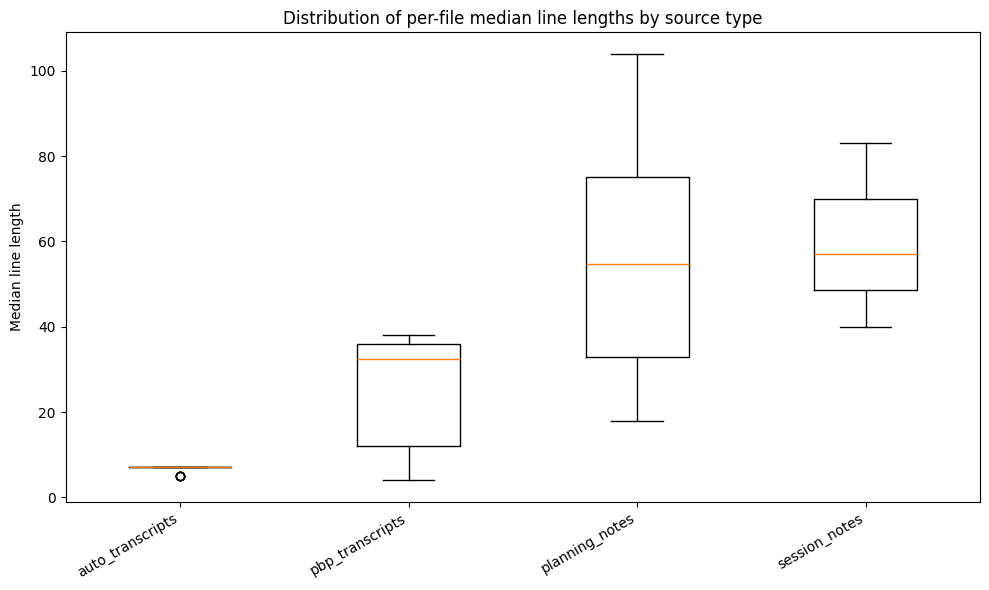

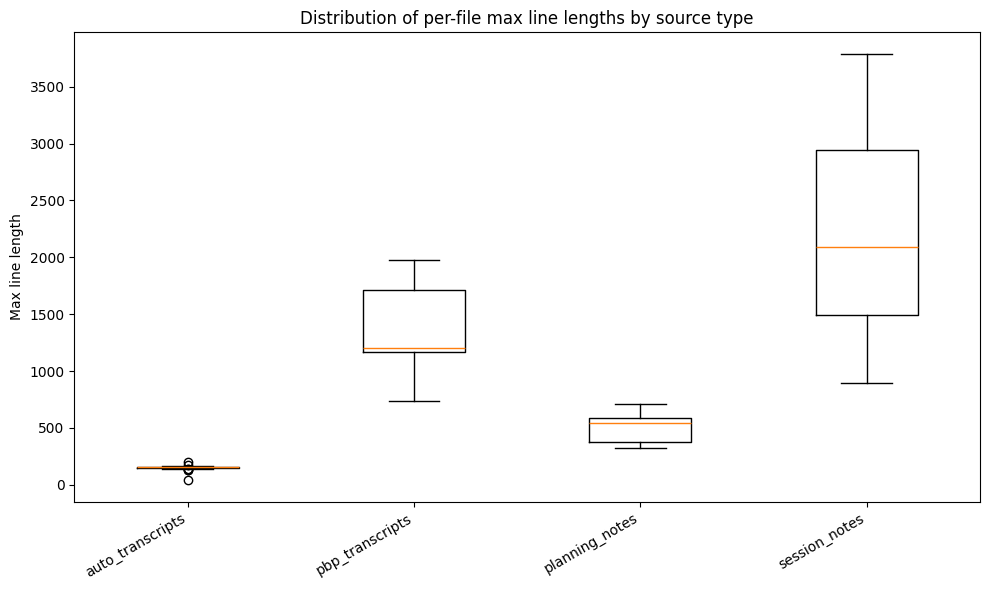

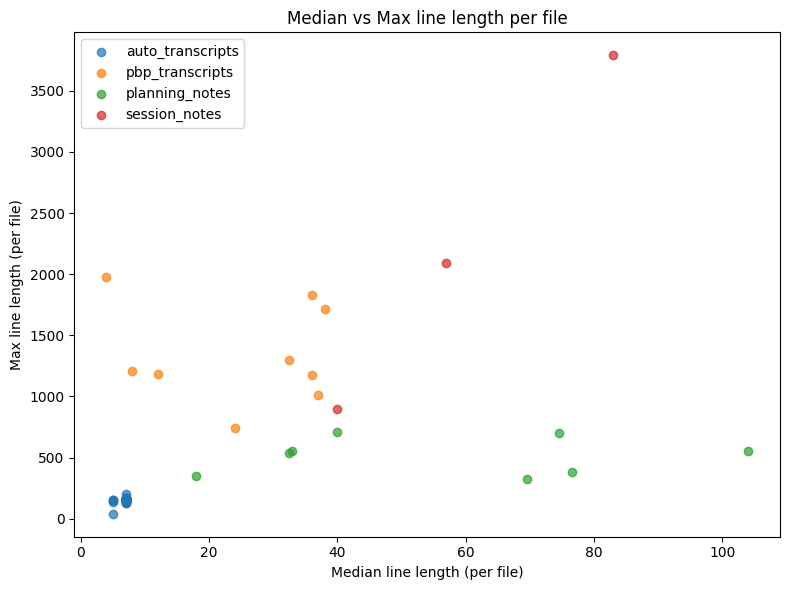

In [25]:
# Phase 4c: File-level line length profiling and charts
# Observational only — no persistence, no mutation

from collections import defaultdict
from statistics import mean, median
import matplotlib.pyplot as plt
import numpy as np

if not LOADED_SOURCES:
    raise ValueError("No loaded sources found. Run Phase 3 first.")

# --- collect per-file 5-number summaries ---
file_profiles = []

for src in LOADED_SOURCES:
    lengths = sorted(len(l) for l in src["lines"] if l)

    if not lengths:
        continue

    q1 = np.percentile(lengths, 25)
    q3 = np.percentile(lengths, 75)

    file_profiles.append({
        "source_type": src["source_type"],
        "min": lengths[0],
        "q1": q1,
        "median": median(lengths),
        "q3": q3,
        "max": lengths[-1],
    })

# --- group by source_type ---
by_type = defaultdict(list)
for p in file_profiles:
    by_type[p["source_type"]].append(p)

# --- Box plots: distribution of medians by source type ---
plt.figure(figsize=(10, 6))

labels = []
data = []

for source_type in sorted(by_type.keys()):
    labels.append(source_type)
    data.append([p["median"] for p in by_type[source_type]])

plt.boxplot(data, tick_labels=labels, showfliers=True)
plt.title("Distribution of per-file median line lengths by source type")
plt.ylabel("Median line length")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Box plots: distribution of max line lengths by source type ---
plt.figure(figsize=(10, 6))

labels = []
data = []

for source_type in sorted(by_type.keys()):
    labels.append(source_type)
    data.append([p["max"] for p in by_type[source_type]])

plt.boxplot(data, tick_labels=labels, showfliers=True)
plt.title("Distribution of per-file max line lengths by source type")
plt.ylabel("Max line length")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Scatter: median vs max (outlier detector) ---
plt.figure(figsize=(8, 6))

for source_type in sorted(by_type.keys()):
    medians = [p["median"] for p in by_type[source_type]]
    maxes = [p["max"] for p in by_type[source_type]]
    plt.scatter(medians, maxes, label=source_type, alpha=0.7)

plt.xlabel("Median line length (per file)")
plt.ylabel("Max line length (per file)")
plt.title("Median vs Max line length per file")
plt.legend()
plt.tight_layout()
plt.show()

# cleanup
del src, lengths, q1, q3, p
del labels, data, medians, maxes
del file_profiles, by_type


## Generate draft index

## Emit outputs